In [1]:
import numpy as np
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
Train_Data = datasets.FashionMNIST(root = 'DataFMnist', train = True, download = True, transform = ToTensor())
Test_Data = datasets.FashionMNIST(root = 'DataFMnist', train = False, download = True, transform = ToTensor())

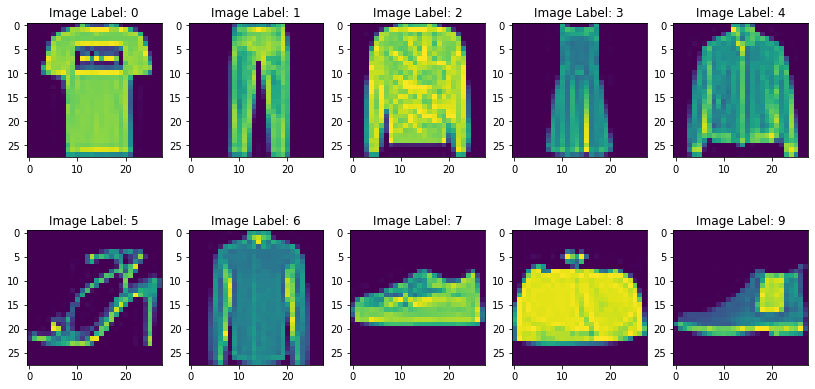

In [4]:
count = 0
plt.figure(1, figsize = (14, 7))
xx, yy = Train_Data[0]
for i, (X, y) in enumerate(Train_Data):
  if y == count:
    plt.subplot(2, 5, count + 1)
    plt.imshow(X.squeeze())
    plt.title(f'Image Label: {y}')
    count += 1
  if count == 10:
    break




In [6]:
class LinLayer:
  def __init__(self, n_inp, n_out, device):
    self.n_inp = n_inp
    self.n_out = n_out
    self.device = device
    self.w = torch.normal(0, np.sqrt(2/(n_inp + n_out)), size = (n_inp, n_out), requires_grad = True, device = self.device)
    self.b = torch.zeros(1, n_out, requires_grad = True, device = self.device)
  def forward(self, x_in):
    return x_in @ (self.w) + self.b

def Relu(x):
  x[x < 0] = 0
  return x

def Softmax(x):
  z = torch.exp(x)
  s = torch.sum(z, dim = 1)
  sd = torch.diag(1/s)
  return sd @ z

def CE_loss(ypred, y):
  L_batch = len(y)
  logp = -torch.log(ypred[np.arange(L_batch),y])
  loss = torch.sum(logp)/L_batch
  return loss


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
class NeNet:
  def __init__(self, Device):
    self.Lin1 = LinLayer(28*28, 700, Device)
    self.Lin2 = LinLayer(700, 700, Device)
    self.Lin3 = LinLayer(700, 400, Device)
    self.Lin4 = LinLayer(400, 10, Device)
    #self.Lin5 = LinLayer(100, 10, Device)
    self.layers = [self.Lin1, self.Lin2, self.Lin3, self.Lin4]
  
  def forward(self, x_in):
    x_out = torch.flatten(x_in, start_dim = 1)
    for layer in self.layers:
      x_out = layer.forward(x_out)
      x_out = Relu(x_out)
    return Softmax(x_out)
  
  def update(self, lr):
    for lay in self.layers:
      with torch.no_grad():
        lay.w -= lr*((lay.w).grad)
        lay.b -= lr*((lay.b).grad)
      lay.w.grad.zero_()
      lay.b.grad.zero_()


In [13]:
import torch.utils.data as data_utils
model = NeNet(device)
LearningRate0 = 0.05
epoch = 6
minibatch = 64
train_dataloader = data_utils.DataLoader(Train_Data, batch_size = minibatch, shuffle = True)
test_dataloader = data_utils.DataLoader(Test_Data, batch_size= minibatch, shuffle = True)

In [14]:
def train_loop(model, dataloader, LR):
   LD = len(dataloader.dataset)
   for i, (X, y) in enumerate(dataloader):
     X, y = X.to(device), y.to(device)
     ypred = model.forward(X)
     loss = CE_loss(ypred, y)
     loss.backward()
     model.update(LR)
     if i % 100 == 0:
       print(f'loss = {loss.item():5f}     [{i*minibatch:5}\{LD:5}]')
def test_loop(model, dataloader):
   LD = len(dataloader.dataset)
   LB = len(dataloader)
   loss = 0
   Accu = 0
   for i, (X, y) in enumerate(dataloader):
     X, y = X.to(device), y.to(device)
     with torch.no_grad():
        ypred = model.forward(X)
        loss += CE_loss(ypred, y)
        Accu += (torch.argmax(ypred, dim = 1)==y).type(torch.float).sum().item()
   print(f'Test Loss = {loss.item()/LB:5f}  ,  Accuracy = {100*Accu/LD}%')

In [15]:
for k in range(epoch):
  print(f'\Epoch: {k} ######################################')
  LearningRate = LearningRate0 #/ 10 if k>=5 else LearningRate0
  train_loop(model, train_dataloader, LearningRate)
  test_loop(model, test_dataloader)
print('Done!')

\Epoch: 0 ######################################
loss = 2.326231     [    0\60000]
loss = 1.259739     [ 6400\60000]
loss = 0.713399     [12800\60000]
loss = 1.106236     [19200\60000]
loss = 1.110403     [25600\60000]
loss = 0.732582     [32000\60000]
loss = 0.951507     [38400\60000]
loss = 0.802732     [44800\60000]
loss = 1.033363     [51200\60000]
loss = 0.671005     [57600\60000]
Test Loss = 0.711237  ,  Accuracy = 78.96%
\Epoch: 1 ######################################
loss = 0.803105     [    0\60000]
loss = 0.749576     [ 6400\60000]
loss = 0.772985     [12800\60000]
loss = 0.596682     [19200\60000]
loss = 0.487225     [25600\60000]
loss = 0.488411     [32000\60000]
loss = 0.533502     [38400\60000]
loss = 0.684996     [44800\60000]
loss = 0.392913     [51200\60000]
loss = 0.552953     [57600\60000]
Test Loss = 0.649034  ,  Accuracy = 80.36%
\Epoch: 2 ######################################
loss = 0.483035     [    0\60000]
loss = 0.516870     [ 6400\60000]
loss = 0.454354    

10000 tensor([9595, 2565, 6526, 3377, 5557, 2441, 1400, 9321, 4494])
<class 'torch.utils.data.dataset.Subset'>


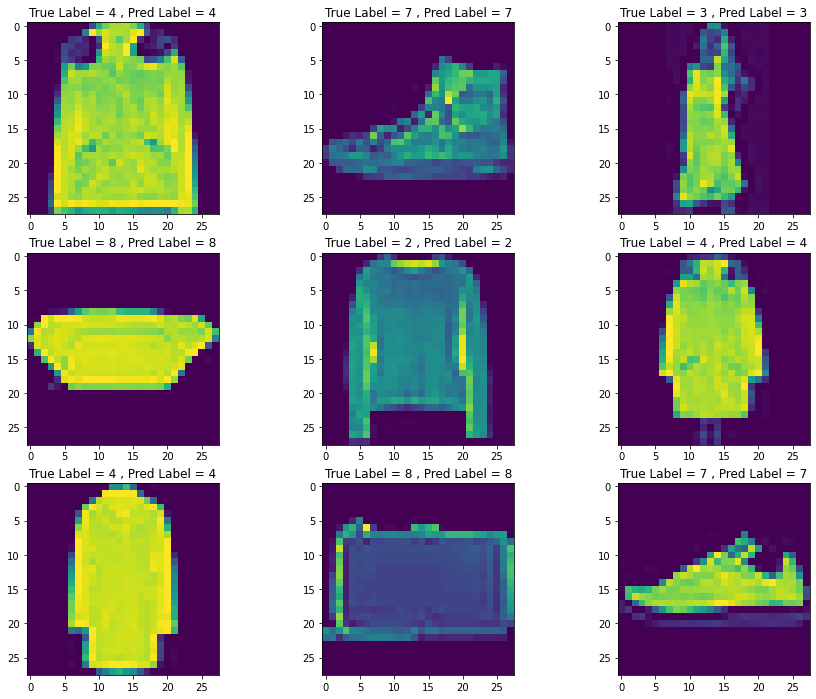

In [16]:
ShuffIdx = torch.randperm(len(Test_Data))
Idx = ShuffIdx[0:9]
print(len(ShuffIdx), Idx)
Rand_Data = data_utils.Subset(Test_Data, indices = Idx)
print(type(Rand_Data))
plt.figure(figsize=(15, 12))
for i, (X, y) in enumerate(Rand_Data):
    y1 = torch.tensor(y)
    X1, y1 = X.to(device), y1.to(device)
    with torch.no_grad():
        ypred = model.forward(X1)
        IdxPred = torch.argmax(ypred, dim = 1).item()
    plt.subplot(3, 3, i + 1)
    plt.imshow(X.squeeze()), plt.title(f'True Label = {y} , Pred Label = {IdxPred}')
    